In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Physics parameters 
rho = 8.0e-3     # ion gyroradius based on electron temperature
eta = 7.5e-5     # electrical resistivity
mu  = 7.5e-5     # viscosity
x0  = 0.25       # x position of the line current
z0  = 0.5        # z position of the line current

# Numerical settings
L   = 0.5        # length of the simulation square (x>0 region)
nx  = 401        # number of grids in x direction
nz  = 1024       # number of grids in z direction
ng  = 2          # number of ghost grids for 5-points central scheme
hx  = L/(nx-1)   # unit size in x direction
hz  = L/(nz-1)   # unit size in z direction
T   = 1.0       # simulation time
nt  = 1000       # number of time steps
dt  = T/nt       # time step

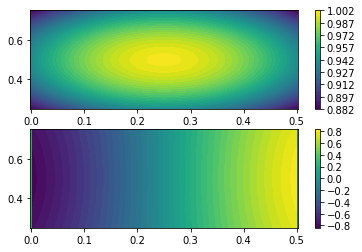

In [5]:
# Initial condition
'''
mu_0  = 4*np.pi*10e-7             # vacuum permeability
I     = 1.                        # line current
k     = 1.                        # slope of the odd scalar potential
psi_0 = mu_0*I/(4*np.pi)          # coefficient of psi              
xi_0  = 6*k*(mu_0*I/(4*np.pi))**2 # coefficient of xi

aold = np.zeros([nz+2*ng, nx+2*ng]) # RHS of eq.(8a)
bold = np.zeros([nz+2*ng, nx+2*ng]) # RHS of eq.(8b)

for i in range(nz):
    for j in range(nx):
        x = j*hx
        z = i*hz+0.25
        aold[i+2,j+2] = - psi_0 / np.sqrt((x-x0)**2+(z-z0)**2)
        bold[i+2,j+2] = - xi_0*(x-x0)**3 / ((x-x0)**2+(z-z0)**2)**4
'''
aold = np.zeros([nz+2*ng, nx+2*ng]) # RHS of eq.(8a)
bold = np.zeros([nz+2*ng, nx+2*ng]) # RHS of eq.(8b)

for i in range(nz):
    for j in range(nx):
        x = j*hx
        z = i*hz+0.25
        aold[i+2,j+2] = np.exp(-(x-x0)**2-(z-z0)**2)
        bold[i+2,j+2] = 4*(x-x0)*(1-2*(x-x0)**2)*np.exp(-(x-x0)**2-(z-z0)**2)

# Boundary conditions
# Top
aold[0]    = aold[-5]
aold[1]    = aold[-4]
bold[0]    = bold[-5]
bold[1]    = bold[-4]
# Bottom 
aold[-2]   = aold[3]
aold[-1]   = aold[4]
bold[-2]   = bold[3]
bold[-1]   = bold[4]
# Left 
aold[:,0]  = aold[:,4]  # phi is even about x
aold[:,1]  = aold[:,3]  
bold[:,0]  = -bold[:,4] # psi is odd about x
bold[:,1]  = -bold[:,3]
# Right 
aold[:,-2] = aold[:,-4]
aold[:,-1] = aold[:,-5]
bold[:,-2] = -bold[:,-4]
bold[:,-1] = -bold[:,-5]

plt.subplot(211)
x = np.linspace(0-2*hx,0.5+2*hx,401+4)
z = np.linspace(0.25-2*hz,0.75+2*hz,1024+4)
cont = plt.contourf(x,z,aold,levels=42)
cbar = plt.colorbar(cont)

plt.subplot(212)
x = np.linspace(0-2*hx,0.5+2*hx,401+4)
z = np.linspace(0.25-2*hz,0.75+2*hz,1024+4)
cont = plt.contourf(x,z,bold,levels=42)
cbar = plt.colorbar(cont)

In [6]:
# 1st-order partial derivatives
def px(f, dx):
    return (-f[2:-2,4:]+8*f[2:-2,3:-1]-8*f[2:-2,1:-3]+f[2:-2,:-4]) / (12*dx)

def pz(f, dz):
    return (-f[4:,2:-2]+8*f[3:-1,2:-2]-8*f[1:-3,2:-2]+f[:-4,2:-2]) / (12*dz)

# 2nd-order partial derivatives
def pxx(f, dx):
    return (-f[2:-2,4:]+16*f[2:-2,3:-1]-30*f[2:-2,2:-2]+16*f[2:-2,1:-3]-f[2:-2,:-4]) / (12*dx**2)

def pzz(f, dz):
    return (-f[4:,2:-2]+16*f[3:-1,2:-2]-30*f[2:-2,2:-2]+16*f[1:-3,2:-2]-f[:-4,2:-2]) / (12*dz**2)

def pxz(f, dx, dz):
    s1 = - f[4:,4:]   + 8*f[3:-1,4:]   - 8*f[1:-3,4:]   + f[:-4,4:]
    s2 = - f[4:,3:-1] + 8*f[3:-1,3:-1] - 8*f[1:-3,3:-1] + f[:-4,3:-1]
    s3 = - f[4:,1:-3] + 8*f[3:-1,1:-3] - 8*f[1:-3,1:-3] + f[:-4,1:-3]
    s4 = - f[4:,:-4]  + 8*f[3:-1,:-4]  - 8*f[1:-3,0:-4] + f[:-4,:-4]
    return (- s1 + 8*s2 - 8*s3 + s4) / (144*dx*dz)

# 3rd-order partial derivatives
def px3(f, dx):
    return (f[2:-2,4:]-2*f[2:-2,3:-1]+2*f[2:-2,1:-3]-f[2:-2,:-4]) / (2*dx**3)

def pz3(f, dz):
    return (f[4:,2:-2]-2*f[3:-1,2:-2]+2*f[1:-3,2:-2]-f[:-4,2:-2]) / (2*dz**3)

def pxxz(f, dx, dz):
    s1 = - f[4:,4:]   + 16*f[4:,3:-1]   - 30*f[4:,2:-2]   + 16*f[4:,1:-3]   - f[4:,:-4]
    s2 = - f[3:-1,4:] + 16*f[3:-1,3:-1] - 30*f[3:-1,2:-2] + 16*f[3:-1,1:-3] - f[3:-1,:-4]
    s3 = - f[1:-3,4:] + 16*f[1:-3,3:-1] - 30*f[1:-3,2:-2] + 16*f[1:-3,1:-3] - f[1:-3,:-4]
    s4 = - f[:-4,4:]  + 16*f[:-4,3:-1]  - 30*f[:-4,2:-2]  + 16*f[:-4,1:-3]  - f[:-4,:-4]
    return (- s1 + 8*s2 - 8*s3 + s4) / (12*dx**2) / (12*dz)

def pxzz(f, dx, dz):
    s1 = - f[4:,4:]   + 16*f[3:-1,4:]    -30*f[2:-2,4:]   + 16*f[1:-3,4:]   - f[:-4,4:]
    s2 = - f[4:,3:-1] + 16*f[3:-1,3:-1]  -30*f[2:-2,3:-1] + 16*f[1:-3,3:-1] - f[:-4,3:-1]
    s3 = - f[4:,1:-3] + 16*f[3:-1,1:-3]  -30*f[2:-2,1:-3] + 16*f[1:-3,1:-3] - f[:-4,1:-3]
    s4 = - f[4:,:-4]  + 16*f[3:-1,:-4]   -30*f[2:-2,:-4]  + 16*f[1:-3,:-4]  - f[:-4,:-4]
    return (- s1 + 8*s2 - 8*s3 + s4) / (12*dz**2) / (12*dx)

In [7]:
def astepper(psi, xi, dx, dz, dt):
    Tcross = np.multiply(px(psi,dx), pz(psi,dz))
    return (2*eta*(np.multiply(np.power(px(psi,dx),2), pxx(psi,dx))\
                  +2*np.multiply(Tcross, pxz(psi,dx,dz))\
                  +np.multiply(np.power(pz(psi,dz),2), pzz(psi,dz)))\
           -rho**2*(np.multiply(pz(psi,dz), px(xi,dx)) - np.multiply(px(psi,dx),pz(xi,dz))))*dt

def bstepper(psi, xi, dx, dz, dt):
    Tcross = np.multiply(px(psi,dx), pz(psi,dz))
    
    T1a = 2*(np.power(pxx(psi,dx),2)-np.power(pzz(psi,dz),2))
    T1b = np.multiply(px(psi,dx), px3(psi,dx)) - np.multiply(pz(psi,dz), pz3(psi,dz))
    T1c = np.multiply(2*pz(psi,dz)-px(psi,dx),pxxz(psi,dx,dz)) \
    + np.multiply(pz(psi,dz)-2*px(psi,dx),pxzz(psi,dx,dz))
    T1  = 2*np.multiply(Tcross, T1a+T1b+T1c) \
    + 2*np.multiply(np.multiply(pxz(psi,dx,dz), pxx(psi,dx)+pzz(psi,dz)), \
                    np.power(pz(psi,dz),2)-np.power(px(psi,dx),2))
    
    T2a = np.multiply(np.power(px(psi,dx),2), pxx(xi,dx)) \
    +2*np.multiply(Tcross,pxz(xi,dx,dz)) \
    +np.multiply(np.power(pz(psi,dz),2), pzz(xi,dz))
    T2b = np.multiply(np.multiply(px(psi,dx),pxx(psi,dx))+np.multiply(pz(psi,dz), pxz(psi,dx,dz)), px(xi,dx)) \
    +np.multiply(np.multiply(pz(psi,dz),pzz(psi,dz))+np.multiply(px(psi,dx), pxz(psi,dx,dz)), pz(xi,dz))
    
    return (T1+mu*(T2a+T2b))*dt

In [8]:
# Stepper
anew = np.zeros([nz+2*ng, nx+2*ng]) # updated array at n+1
btpr = np.zeros([nz+2*ng, nx+2*ng]) # temporary array at n+1/2
bnew = np.zeros([nz+2*ng, nx+2*ng]) # updated array at n+1

for k in range(10):
    # Leap-frog
    btpr[2:-2,2:-2] = bold[2:-2,2:-2] + bstepper(aold,bold,hx,hz,dt*0.5)
    anew[2:-2,2:-2] = aold[2:-2,2:-2] + astepper(aold,btpr,hx,hz,dt)
    bnew[2:-2,2:-2] = btpr[2:-2,2:-2] + bstepper(anew,btpr,hx,hz,dt*0.5)
    
    # Boundary: top
    anew[0]    = anew[-5]
    anew[1]    = anew[-4]
    bnew[0]    = bnew[-5]
    bnew[1]    = bnew[-4]
    # Boundary: bottom 
    anew[-2]   = anew[3]
    anew[-1]   = anew[4]
    bnew[-2]   = bnew[3]
    bnew[-1]   = bnew[4]
    # Boundary: left 
    anew[:,0]  = anew[:,4]  # phi is even about x
    anew[:,1]  = anew[:,3]  
    bnew[:,0]  = -bnew[:,4] # psi is odd about x
    bnew[:,1]  = -bnew[:,3]
    # Boundary: right 
    anew[:,-2] = anew[:,-4]
    anew[:,-1] = anew[:,-5]
    bnew[:,-2] = -bnew[:,-4]
    bnew[:,-1] = -bnew[:,-5]  
    
    # Update the result
    aold = anew
    bold = bnew
    
    if (k%100==0):
        print(anew[500])
        print(bnew[500])

[0.94054073 0.93996065 0.93937292 0.93996065 0.94054073 0.94112191
 0.94169994 0.94227543 0.94284833 0.94341863 0.94398633 0.94455142
 0.94511389 0.94567374 0.94623096 0.94678556 0.94733752 0.94788684
 0.94843351 0.94897754 0.9495189  0.95005761 0.95059366 0.95112703
 0.95165773 0.95218575 0.95271108 0.95323373 0.95375368 0.95427094
 0.95478549 0.95529733 0.95580646 0.95631287 0.95681656 0.95731753
 0.95781576 0.95831126 0.95880402 0.95929404 0.9597813  0.96026581
 0.96074757 0.96122656 0.96170279 0.96217624 0.96264692 0.96311482
 0.96357994 0.96404227 0.9645018  0.96495854 0.96541248 0.96586362
 0.96631194 0.96675745 0.96720015 0.96764002 0.96807707 0.96851129
 0.96894268 0.96937123 0.96979694 0.9702198  0.97063982 0.97105698
 0.97147128 0.97188273 0.97229131 0.97269702 0.97309986 0.97349983
 0.97389691 0.97429112 0.97468244 0.97507086 0.9754564  0.97583904
 0.97621877 0.9765956  0.97696953 0.97734054 0.97770864 0.97807382
 0.97843609 0.97879542 0.97915183 0.97950531 0.97985585 0.9802

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in add
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in add
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in power
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in add
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in add


In [37]:
print(np.argmax(anew), np.argmin(anew))
print(anew[500])

0 0
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

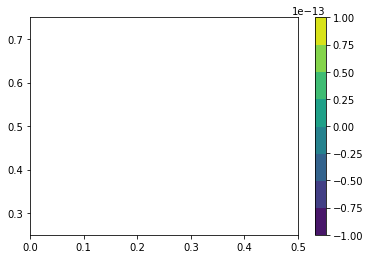

In [32]:
x = np.linspace(0,0.5,401)
z = np.linspace(0.25,0.75,1024)
cont = plt.contourf(x,z,anew[2:-2,2:-2])
cbar = plt.colorbar(cont)

In [24]:
print(np.amax(anew), np.amin(anew))

nan nan


In [26]:
print(anew[500])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na